<a href="https://colab.research.google.com/github/xtcxxr/face-mask-detection/blob/main/CIS545_Final_Porject_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS545: Face Mask Detection

Due to the rapid spread of COVID 19, wearing masks becomes compulsory to protect us against the deadly virus. An accurate and reliable system to conduct face mask detection would be extremely helpful in public spaces. In this project, we take the face mask detection image dataset and its compliment csv and json files. Our data processing process including cleaning and sorting, getting rid of unrelated and duplicate information. We also preprocess all images by cropping them to only includes the human face part, adding edge detection layer to the original image. The edge detection process is applied to add more features to the dataset. We developed three different models and pick the one with the highest testing accuracy ro conduct the final prediction on our test dataset. MTCNN package is used to detect human faces for images in test dataset in this project.

## Imports and Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from scipy import signal
import cv2
import os
import sys
import seaborn as sns

In [ ]:
!pip install mtcnn
from mtcnn.mtcnn import MTCNN

In [ ]:
!pip install torch torchvision
!pip install opencv-python
import shutil
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.models as models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT, force_remount=True)

Mounted at /content/gdrive


## Loading and Exploring Data

Shown below is the dataframe read from train.csv sorted by image name. As shown in the dataframe, there could be multiple rows for each image identified by the name column. Each row represents a certain rectangle area, for which the location is specified by x1, x2, y1, y2, and the content is indicated by the classname corresponding to each row.


In [ ]:
train_df = pd.read_csv("/content/gdrive/MyDrive/CIS545_Final_Project/face-mask-detection-test/train.csv")
train_df.sort_values("name", inplace = True, ignore_index=True)
train_df

,name,x1,x2,y1,y2,classname
0,1801.jpg,451,186,895,697,face_no_mask
1,1802.jpg,160,151,268,265,mask_surgical
2,1802.jpg,110,71,273,272,face_with_mask
3,1803.jpg,147,200,288,320,mask_surgical
4,1803.jpg,126,75,303,333,face_with_mask
...,...,...,...,...,...,...
15407,6433.png,669,205,774,282,mask_surgical
15408,6434.jpg,315,82,775,783,face_with_mask
15409,6434.jpg,343,448,756,774,mask_colorful
15410,6435.jpg,198,86,292,149,mask_surgical


In [ ]:
train_df.shape

(12398, 7)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12398 entries, 0 to 15411
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       12398 non-null  object
 1   x1         12398 non-null  int64 
 2   x2         12398 non-null  int64 
 3   y1         12398 non-null  int64 
 4   y2         12398 non-null  int64 
 5   classname  12398 non-null  object
 6   label      12398 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.1+ MB


In [ ]:
train_df.describe()

,x1,x2,y1,y2,label
count,12398.000000,12398.000000,12398.000000,12398.000000,12398.000000
mean,343.370947,156.172447,530.670027,364.047104,3.750766
std,309.299428,167.275906,393.316152,292.770325,2.056354
min,0.000000,0.000000,13.000000,16.000000,0.000000
25%,155.000000,52.000000,337.000000,208.000000,2.000000
50%,279.000000,127.000000,461.500000,306.000000,5.000000
75%,439.000000,215.000000,613.000000,444.000000,5.000000
max,3598.000000,3549.000000,4912.000000,4370.000000,11.000000


In [ ]:
train_df.dtypes

name         object
x1            int64
x2            int64
y1            int64
y2            int64
classname    object
label         int64
dtype: object

To better understanding how this dataset works, we pick an example image from the image dataset and plot out the information in corresponding rows. Shown below is the visualized data for image 1802.jpg.

In [ ]:
def face_mask_rectangle(index, df):
    image_to_process = df["name"][index]
    print(image_to_process)
    info = df[df["name"] == image_to_process]
    classnames = info["classname"]
    rectangles = info[["x1", "x2", "y1", "y2"]]
    x1 = rectangles["x1"][index]
    x2 = rectangles["x2"][index]
    y1 = rectangles["y1"][index]
    y2 = rectangles["y2"][index]
    classname = classnames[index]
    images = "/content/gdrive/MyDrive/CIS545_Final_Project/face-mask-detection-test/Medical mask/Medical mask/Medical Mask/images"
    image_path = os.path.join(images, image_to_process)
    image_plt = plt.imread(image_path)
    return x1, x2, y1, y2, classname, image_plt

1802.jpg
1802.jpg


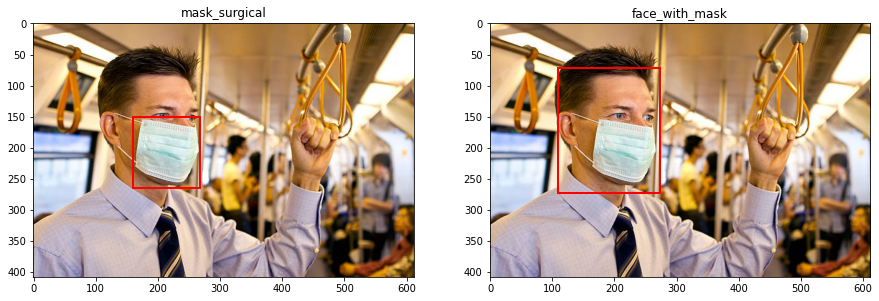

In [ ]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15,15))

x1, x2, y1, y2, classname, image_plt = face_mask_rectangle(1, train_df)
ax1.imshow(image_plt)
rect1 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax1.set_title(classname)

x1, x2, y1, y2, classname, image_plt = face_mask_rectangle(2, train_df)
ax2.imshow(image_plt)
rect2 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax2.set_title(classname)

ax1.add_patch(rect1)
ax2.add_patch(rect2)

plt.show()

We manually create labels using meta.json and map the labels to train_df. As shown below, there are 20 different classes in total. We map these classes to integer from 0 to 19 and add a label column to train_df as labels for each image in the dataset.

In [ ]:
mask_type = pd.read_json("/content/gdrive/MyDrive/CIS545_Final_Project/face-mask-detection-test/Medical mask/Medical mask/meta.json")
mask_category_list = []
mask_category = {}

for i in mask_type["classes"]:
    mask_category_list.append(i["title"])
for i in range(20):
    key = mask_category_list[i]
    mask_category[key] = i
print(mask_category)

{'hijab_niqab': 0, 'mask_colorful': 1, 'mask_surgical': 2, 'face_no_mask': 3, 'face_with_mask_incorrect': 4, 'face_with_mask': 5, 'face_other_covering': 6, 'scarf_bandana': 7, 'balaclava_ski_mask': 8, 'face_shield': 9, 'other': 10, 'gas_mask': 11, 'turban': 12, 'helmet': 13, 'sunglasses': 14, 'eyeglasses': 15, 'hair_net': 16, 'hat': 17, 'goggles': 18, 'hood': 19}


In [ ]:
category_name = train_df['classname'].apply(lambda x: mask_category[x])
train_df.insert(6, 'label', category_name)
train_df

,name,x1,x2,y1,y2,classname,label
0,1801.jpg,451,186,895,697,face_no_mask,3
1,1802.jpg,160,151,268,265,mask_surgical,2
2,1802.jpg,110,71,273,272,face_with_mask,5
3,1803.jpg,147,200,288,320,mask_surgical,2
4,1803.jpg,126,75,303,333,face_with_mask,5
...,...,...,...,...,...,...,...
15407,6433.png,669,205,774,282,mask_surgical,2
15408,6434.jpg,315,82,775,783,face_with_mask,5
15409,6434.jpg,343,448,756,774,mask_colorful,1
15410,6435.jpg,198,86,292,149,mask_surgical,2


We draw a simple bar plot to show how many classes do we have and the counts of each class.

In [ ]:
def classCount(name):
    return (train_df['classname'] == name).sum()

In [ ]:
classname_list = []
count_list = []
for key in mask_category:
  classname_list.append(key)
  count = classCount(key)
  count_list.append(count)
print(count_list)
print(classname_list)


[173, 1876, 2430, 1569, 150, 4180, 1372, 260, 134, 160, 39, 55, 94, 187, 358, 914, 287, 823, 192, 159]
['hijab_niqab', 'mask_colorful', 'mask_surgical', 'face_no_mask', 'face_with_mask_incorrect', 'face_with_mask', 'face_other_covering', 'scarf_bandana', 'balaclava_ski_mask', 'face_shield', 'other', 'gas_mask', 'turban', 'helmet', 'sunglasses', 'eyeglasses', 'hair_net', 'hat', 'goggles', 'hood']


Text(0.5, 1.0, 'Count of classnames')

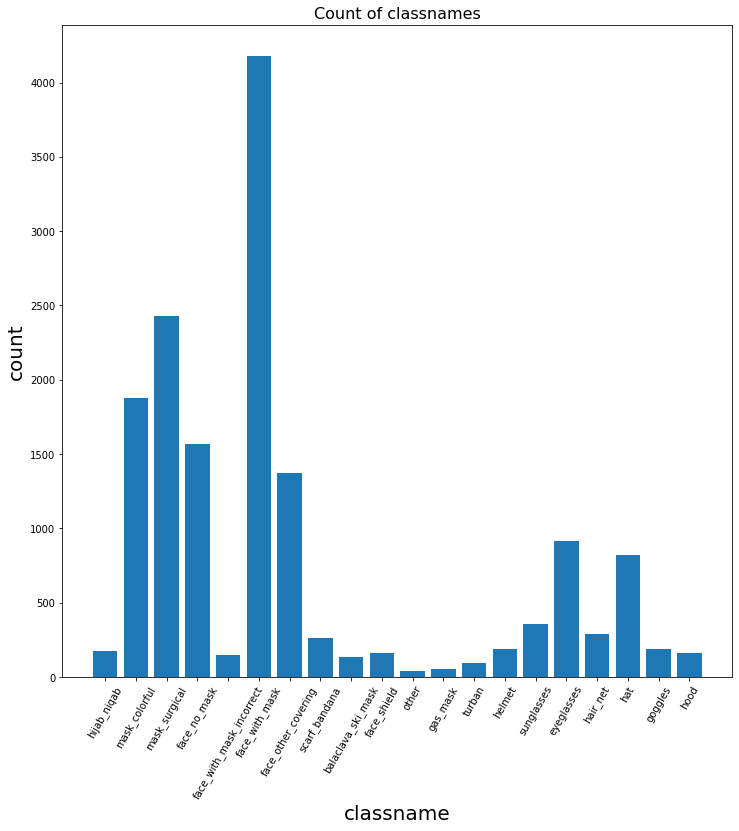

In [ ]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.bar(classname_list, count_list)
plt.ylabel('count',fontsize = 20)
plt.xlabel('classname', fontsize = 20)
plt.xticks(rotation=60)   
plt.title('Count of classnames', fontsize = 16) 

For this project, we focus on detecting whether people are wearing face masks, what kind of masks they are wearing, as well as if they wear the masks correctly. Thus, we decide to remove some unrelated labels from the dataset, such as helmet, hat, eyeglasses, etc.

In [ ]:
turban = train_df[train_df['label'] == 12].index
helmet = train_df[train_df['label'] == 13].index
sunglasses = train_df[train_df['label'] == 14].index
eyeglasses = train_df[train_df['label'] == 15].index
hair_net = train_df[train_df['label'] == 16].index
hat = train_df[train_df['label'] == 17].index
goggles = train_df[train_df['label'] == 18].index
hood = train_df[train_df['label'] == 19].index

In [ ]:
train_df.drop(turban, inplace=True,)
train_df.drop(helmet, inplace=True)
train_df.drop(sunglasses, inplace=True)
train_df.drop(eyeglasses, inplace=True)
train_df.drop(hair_net, inplace=True)
train_df.drop(hat, inplace=True)
train_df.drop(goggles, inplace=True)
train_df.drop(hood, inplace=True)

In [ ]:
train_df_copy = train_df.copy(deep=True)
train_df_copy.sort_values("name", inplace = True, ignore_index=True)
train_df_copy

,name,x1,x2,y1,y2,classname,label
0,1801.jpg,451,186,895,697,face_no_mask,3
1,1802.jpg,160,151,268,265,mask_surgical,2
2,1802.jpg,110,71,273,272,face_with_mask,5
3,1803.jpg,147,200,288,320,mask_surgical,2
4,1803.jpg,126,75,303,333,face_with_mask,5
...,...,...,...,...,...,...,...
12393,6433.png,669,205,774,282,mask_surgical,2
12394,6434.jpg,315,82,775,783,face_with_mask,5
12395,6434.jpg,343,448,756,774,mask_colorful,1
12396,6435.jpg,198,86,292,149,mask_surgical,2


In [ ]:
train_df_copy.sort_values("name", inplace = True, ignore_index=True)
train_df_copy.drop_duplicates(subset ="name", keep = "first", inplace = True)
train_df_copy

,name,x1,x2,y1,y2,classname,label
0,1801.jpg,451,186,895,697,face_no_mask,3
1,1802.jpg,160,151,268,265,mask_surgical,2
2,1803.jpg,147,200,288,320,mask_surgical,2
3,1804.jpg,127,194,243,293,mask_surgical,2
4,1805.jpg,728,180,853,336,face_with_mask,5
...,...,...,...,...,...,...,...
4321,6431.png,720,298,935,472,mask_colorful,1
4322,6432.jpg,369,125,439,180,mask_surgical,2
4323,6433.png,536,235,656,330,mask_surgical,2
4324,6434.jpg,315,82,775,783,face_with_mask,5


In [ ]:
submission_df = pd.read_csv("/content/gdrive/MyDrive/CIS545_Final_Project/face-mask-detection-test/submission.csv")
submission_df

,name,x1,x2,y1,y2,classname
0,1800.jpg,NaN,NaN,NaN,NaN,NaN
1,1800.jpg,NaN,NaN,NaN,NaN,NaN
2,1800.jpg,NaN,NaN,NaN,NaN,NaN
3,1799.jpg,NaN,NaN,NaN,NaN,NaN
4,1799.jpg,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
8137,0003.jpg,NaN,NaN,NaN,NaN,NaN
8138,0002.png,NaN,NaN,NaN,NaN,NaN
8139,0001.jpg,NaN,NaN,NaN,NaN,NaN
8140,0001.jpg,NaN,NaN,NaN,NaN,NaN


As shown below, there are 1698 images in the testing dataset. We will test three different models on the testing dataset and choose the model with the highest testing accuracy to conduct the final prediction of labls for each imagein the testing dataset.

In [ ]:
submission_df_copy = submission_df
submission_df_copy.sort_values("name", inplace = True, ignore_index=True)
submission_df_copy.drop_duplicates(subset ="name", keep = "first", inplace = True)
image_to_move = submission_df_copy["name"].to_list()
submission_df_copy

,name,x1,x2,y1,y2,classname
0,0001.jpg,NaN,NaN,NaN,NaN,NaN
3,0002.png,NaN,NaN,NaN,NaN,NaN
4,0003.jpg,NaN,NaN,NaN,NaN,NaN
7,0004.jpg,NaN,NaN,NaN,NaN,NaN
9,0005.jpg,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
8108,1795.jpg,NaN,NaN,NaN,NaN,NaN
8117,1796.jpg,NaN,NaN,NaN,NaN,NaN
8123,1797.jpg,NaN,NaN,NaN,NaN,NaN
8126,1799.jpg,NaN,NaN,NaN,NaN,NaN


## Canny Edge Detection

This section we implement canny edge detetion. The purpose is to add extra features to our dataset to increase the accuracy of our model. We will conduct canny edge detection on all sample images and add it as an extra layer. Edges are the most important element of an image. We can parse the most important information (ie. most important pixels of the image) to our model by conducting edge detection so that the machine learning model will focus on the most important part of the images.

rgb2array() is a function to transform an colorful image to its grey scale image. It amplifies the contrast and intensity of the original image to insure we can get clear edges.

In [ ]:
def rgb2gray(I_rgb):
    r, g, b = I_rgb[:, :, 0], I_rgb[:, :, 1], I_rgb[:, :, 2]
    I_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return I_gray

interp2() is a help function to conduct lineat interpolation to calculate the orientation of edges.

In [ ]:
def interp2(v, xq, yq):
    dim_input = 1
    if len(xq.shape) == 2 or len(yq.shape) == 2:
        dim_input = 2
        q_h = xq.shape[0]
        q_w = xq.shape[1]
        xq = xq.flatten()
        yq = yq.flatten()

    h = v.shape[0]
    w = v.shape[1]
    if xq.shape != yq.shape:
        raise 'query coordinates Xq Yq should have same shape'

    x_floor = np.floor(xq).astype(np.int32)
    y_floor = np.floor(yq).astype(np.int32)
    x_ceil = np.ceil(xq).astype(np.int32)
    y_ceil = np.ceil(yq).astype(np.int32)

    x_floor[x_floor < 0] = 0
    y_floor[y_floor < 0] = 0
    x_ceil[x_ceil < 0] = 0
    y_ceil[y_ceil < 0] = 0

    x_floor[x_floor >= w-1] = w-1
    y_floor[y_floor >= h-1] = h-1
    x_ceil[x_ceil >= w-1] = w-1
    y_ceil[y_ceil >= h-1] = h-1

    v1 = v[y_floor, x_floor]
    v2 = v[y_floor, x_ceil]
    v3 = v[y_ceil, x_floor]
    v4 = v[y_ceil, x_ceil]

    lh = yq - y_floor
    lw = xq - x_floor
    hh = 1 - lh
    hw = 1 - lw

    w1 = hh * hw
    w2 = hh * lw
    w3 = lh * hw
    w4 = lh * lw

    interp_val = v1 * w1 + w2 * v2 + w3 * v3 + w4 * v4

    if dim_input == 2:
        return interp_val.reshape(q_h, q_w)
    
    return interp_val

findDerivatives() is the first step of the actual canny edge detection process. It computes the gradient information of the input grayscale image. This functions uses two Gussian filters do the convolution. The purpose if to filter out noises and find the horizontal derivatives and vertical derivates of hte images. By combining the horizontal and vertical edges found, it calculates the magnitudes and orientations of the actual edges.

In [ ]:
def findDerivatives(I_gray):
    '''
    File clarification:
        Compute gradient information of the input grayscale image
        - Input I_gray: H x W matrix as image
        - Output Mag: H x W matrix represents the magnitude of derivatives
        - Output Magx: H x W matrix represents the magnitude of derivatives along x-axis
        - Output Magy: H x W matrix represents the magnitude of derivatives along y-axis
        - Output Ori: H x W matrix represents the orientation of derivatives
    '''
    # do Gaussian smoothing by Gaussian filter

    Gaussian = np.array([[2, 4, 5, 4, 2],
                         [4, 9, 12, 9, 4],
                         [5, 12, 15, 12, 5],
                         [4, 9, 12, 9, 4],
                         [2, 4, 5, 4, 2]]) / 159

    dx = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]])
    
    dy = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]])
    


    # calculate the derivative in horizontal and vertical direction of the Gaussian filter
    # dx = np.array([1, -1]).reshape(1, 2)
    # dy = np.array([1, -1]).reshape(2, 1)

    G_dx = signal.convolve2d(Gaussian, dx, mode='same')
    G_dy = signal.convolve2d(Gaussian, dy, mode='same')

    # Use the derivative of the Gaussian filter to do Gaussian smoothing and derivative of the Grey image
    Magx = signal.convolve2d(I_gray, G_dx, mode='same')
    Magy = signal.convolve2d(I_gray, G_dy, mode='same')
    Mag = np.sqrt(Magx**2 + Magy**2)
    Ori = np.arctan2(Magy,Magx)

    return Mag, Magx, Magy, Ori

Once we have the derivates and orientations, we now need to find the local maximum edge pixel using NMS(non-maximum suppression) along the line of the gradient point and suppress other unimportant points. nonMaxSup() is implemented for this purpose.

In [ ]:
def nonMaxSup(Mag, Ori):
    '''
    File clarification:
        Find local maximum edge pixel using NMS along the line of the gradient
        - Input Mag: H x W matrix represents the magnitude of derivatives
        - Input Ori: H x W matrix represents the orientation of derivatives
        - Output M: H x W binary matrix represents the edge map after non-maximum suppression
    '''
    
    # getting neighbor in the oritention direction
    
    
    nr, nc = Mag.shape
    x, y = np.meshgrid(np.arange(nc), np.arange(nr))
    cos_Ori = np.cos(Ori)
    sin_Ori = np.sin(Ori)

    ## neighbor 1 location
    N1_x = x + cos_Ori
    N1_y = y + sin_Ori

    # using interpolation to get neighbor
    Mag_neighbor1 = interp2(Mag, N1_x, N1_y)
    Mag_neighbor1[N1_x > nc-1] = 0
    Mag_neighbor1[N1_y > nr-1] = 0
    Mag_neighbor1[N1_x < -1e-10] = 0  # was N1_x < 0
    Mag_neighbor1[N1_y < -1e-10] = 0  # was N1_y < 0


    # getting neighbor in the opposite of the oritention direction
    
    ## neighbot 2 location
    N2_x = x - cos_Ori
    N2_y = y - sin_Ori

    Mag_neighbor2 = interp2(Mag, N2_x, N2_y)
    Mag_neighbor2[N2_x > nc-1] = 0
    Mag_neighbor2[N2_y > nr-1] = 0
    Mag_neighbor2[N2_x < -1e-10] = 0  # was N2_x < 0
    Mag_neighbor2[N2_y < -1e-10] = 0  # was N2_y < 0

    # perform NMS
    binary_map = np.logical_and(Mag >= Mag_neighbor1, Mag >= Mag_neighbor2)

    # if used Mag_neighbor[N_x < 0] = 0, then uncomment this one.
    #binary_map = np.logical_and(Mag > Mag_neighbor1, Mag > Mag_neighbor2)
    return binary_map

edgeLink() uses hysteresis to link edges based on high and low magnitude thresholds. Points above high threshold will form edges of the image. Points below the low threshold are ignored since they must not form edges of the image. For points in between the high threshold and low threshold, we check if those points are related to the edges formed by points above the high threshold to determine whether they form edges or not.

In [ ]:
def edgeLink(M, Mag, Ori, low, high):
    '''
    File clarification:
        Use hysteresis to link edges based on high and low magnitude thresholds
        - Input M: H x W logical map after non-max suppression
        - Input Mag: H x W matrix represents the magnitude of gradient
        - Input Ori: H x W matrix represents the orientation of gradient
        - Input low, high: low and high thresholds 
        - Output E: H x W binary matrix represents the final canny edge detection map
    '''
    # suppress pixels whose magnitude is lower than low threshold
    NMS_Mag = Mag * M

    Mag_lw = NMS_Mag > low   # weak edge

    # initial EdgeMap with strong edges
    Edge_Map = NMS_Mag > high  # strong edge

    # compute the edge direction from Ori
    Edge_dir1 = Ori + np.pi/2

    # find neighbors in the edge direction
    nr, nc = Mag.shape
    x, y = np.meshgrid(np.arange(nc), np.arange(nr))

    cos_Edge = np.cos(Edge_dir1)
    sin_Edge = np.sin(Edge_dir1)

    Edge_N1_x = x + cos_Edge
    Edge_N1_y = y + sin_Edge

    Edge_N2_x = x - cos_Edge
    Edge_N2_y = y - sin_Edge

    while True:

        prev = Edge_Map.copy()
        ## do interpelation to find neighbor and determine if they are edge or not
        # high_map = Edge_Map * NMS_Mag

        ## create neighbor1 strong edge 
        Edge_Neighbor1 = interp2(NMS_Mag, Edge_N1_x, Edge_N1_y)
        Edge_Neighbor1[Edge_N1_x > nc-1] = 0
        Edge_Neighbor1[Edge_N1_y > nr-1] = 0
        Edge_Neighbor1[Edge_N1_x < 0] = 0
        Edge_Neighbor1[Edge_N1_y < 0] = 0

        Edge_Neighbor1_logic = Edge_Neighbor1 > high

        ## create neighbor2 strong edge
        Edge_Neighbor2 = interp2(NMS_Mag, Edge_N2_x, Edge_N2_y)
        Edge_Neighbor2[Edge_N2_x > nc-1] = 0
        Edge_Neighbor2[Edge_N2_y > nr-1] = 0
        Edge_Neighbor2[Edge_N2_x < 0] = 0
        Edge_Neighbor2[Edge_N2_y < 0] = 0   

        Edge_Neighbor2_logic = Edge_Neighbor2 > high

        # check neighbor to add
        Strong_Neighbor1 = np.logical_and(Edge_Neighbor1_logic, Mag_lw)
        Strong_Neighbor2 = np.logical_and(Edge_Neighbor2_logic, Mag_lw)
        Weak_Edge_Add = np.logical_or(Strong_Neighbor1, Strong_Neighbor2)

        Edge_Map[Weak_Edge_Add] = True

        NMS_Mag[Weak_Edge_Add] = np.maximum(Edge_Neighbor1[Weak_Edge_Add], Edge_Neighbor2[Weak_Edge_Add])

        if np.all(prev == Edge_Map):
           break
    return Edge_Map

cannyEdge() combines all above steps to comduct a full canny edge detection process. The input are the original images and two thresholds to detect edges.

In [ ]:
def cannyEdge(I, low, high):
    # convert RGB image to gray color space
    im_gray = rgb2gray(I)

    Mag, Magx, Magy, Ori = findDerivatives(im_gray)
    M = nonMaxSup(Mag, Ori)
    E = edgeLink(M, Mag, Ori, low, high)

    plt.show()

    return E

## Data Preprocessing

saveImages is a function that takes in a dataframe, obtaining corresponding images from the image folder, conducting canny edge detection, and then save the edge detected version of each image to a target folder.

In [ ]:
def saveImages(input_df, image_folder, save_folder):
    """
    return the ith value
    """
    train_df = input_df.drop_duplicates(subset = ['name'], keep = "first").reset_index(drop=True)
    for idx in range(train_df.shape[0]):

        image_path = os.path.join(image_folder, train_df['name'][idx])
        img = Image.open(image_path)

        # canny edge detection
        ori_img = np.array(img.convert('RGB'))
        high = 30
        low = 0.4 * high
        edge_array = cannyEdge(ori_img, low, high)
        pil_image = Image.fromarray(edge_array.astype(np.uint8) * 255).convert('L')

        save_name = train_df['name'][idx].split('.')[0] + '.png'
        save_path = os.path.join(save_folder, save_name)

        pil_image.save(save_path, format='png')

TrainingImageDataset is a function that takes in images and their edge detected verstion based on given dataframe adn generate a dataset for next steps.

In [ ]:
class TrainingImageDataset(Dataset):
    def __init__(self, folder_path, edge_folder, train_df, data_transforms=None):
        """
        load the path of the folder and the 
        """
        self.train_df = train_df.reset_index(drop=True)
        self.image_folder = folder_path
        self.edge_folder = edge_folder
        if (data_transforms is not None):
            self.data_transforms = data_transforms
        else:
            self.data_transforms = transforms.Compose([
                                        transforms.Resize((224,224)), 
                                        transforms.ToTensor(),
                                        ])

    def __len__(self):
        """
        return the length of the dataset
        """
        length = self.train_df.shape[0]
        return length

    def __getitem__(self, idx):
        """
        return the ith value
        """

        # crop and transform the train image
        image_path = os.path.join(self.image_folder, self.train_df['name'][idx])
        img = Image.open(image_path)
        x1 = self.train_df['x1'][idx]
        x2 = self.train_df['x2'][idx]
        y1 = self.train_df['y1'][idx]
        y2 = self.train_df['y2'][idx]
        image_crop = img.crop((x1, x2, y1, y2))
        image_crop_trans = self.data_transforms(image_crop)

        pil_name = self.train_df['name'][idx].split('.')[0] + '.png'
        pil_path = os.path.join(self.edge_folder, pil_name)
        pil_img = Image.open(pil_path)
        pil_crop = pil_img.crop((x1, x2, y1, y2))
        pil_crop_trans = self.data_transforms(pil_crop)

        out_image = torch.zeros(4,224,224)
        out_image[:3, :, :] = image_crop_trans
        out_image[3, :, :] = pil_crop_trans

        out_label = self.train_df['label'][idx]
        output = tuple([out_image,out_label])

        return output

Code commented below is for saving the edge detected version of all images to local drive so that we can directly use them while doing training and testing later. Doing this part seperately saves a lot of time when training and testing the model.

In [ ]:
# train_df_first = train_df.copy(deep=True)
# train_df_first.sort_values("name", inplace = True, ignore_index=True)
# train_df_first.drop_duplicates(subset ="name", keep = "first", inplace = True)
# image_to_move = train_df_first["name"].to_list()
# train_df_first

In [ ]:
# train_df_first1 = train_df_first.head(2000)
# train_df_first1

In [ ]:
# train_df_first2 = train_df_first[2000:4326]
# train_df_first2

In [ ]:
img_folder = "/content/gdrive/MyDrive/CIS545_Final_Project/face-mask-detection/Medical mask/Medical mask/Medical Mask/images"
sav_folder = "/content/gdrive/MyDrive/CIS545_Final_Project/face-mask-detection/edge detection"
# saveImages(train_df_first1, img_folder, sav_folder) 

In [ ]:
# saveImages(train_df_first2, img_folder, sav_folder)

In [ ]:
# saveImages(submission_df_copy, img_folder, sav_folder)

The following code splits the training dataset into train dataset and validation dataset in a 7:3 ratio.

In [ ]:
train_df_train = train_df.head(3028).reset_index(drop=True)
train_df_train

,name,x1,x2,y1,y2,classname,label
0,1801.jpg,451,186,895,697,face_no_mask,3
1,1802.jpg,160,151,268,265,mask_surgical,2
2,1802.jpg,110,71,273,272,face_with_mask,5
3,1803.jpg,147,200,288,320,mask_surgical,2
4,1803.jpg,126,75,303,333,face_with_mask,5
...,...,...,...,...,...,...,...
3023,2869.png,86,3,585,562,face_with_mask,5
3024,2870.png,312,161,402,279,face_with_mask,5
3025,2870.png,10,146,99,257,face_with_mask,5
3026,2870.png,628,160,692,277,face_with_mask,5


In [ ]:
train_df_validation = train_df[3028:4326].reset_index(drop=True)
train_df_validation

,name,x1,x2,y1,y2,classname,label
0,2870.png,640,222,690,276,mask_surgical,2
1,2870.png,25,198,96,253,mask_colorful,1
2,2871.png,461,20,494,93,face_with_mask,5
3,2871.png,162,122,200,144,mask_surgical,2
4,2871.png,111,151,165,194,mask_surgical,2
...,...,...,...,...,...,...,...
1293,3347.png,246,174,306,242,face_with_mask,5
1294,3347.png,135,174,179,209,mask_surgical,2
1295,3347.png,384,173,433,217,face_shield,9
1296,3348.png,278,188,362,278,face_with_mask,5


In [ ]:
train_dataset = TrainingImageDataset(img_folder, sav_folder, train_df_train)
validation_dataset = TrainingImageDataset(img_folder, sav_folder, train_df_validation)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle = True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle = True)

Shown below are examples of canny edge detection versions of our image dataset. The first column of images are the original layers. The second column of images are the added canny edge detection layers.

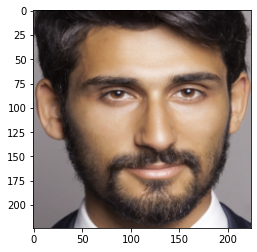

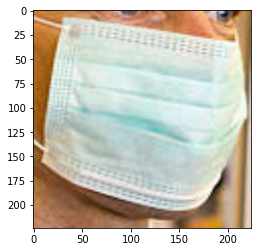

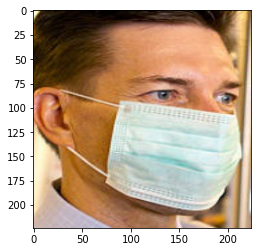

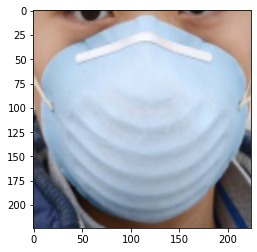

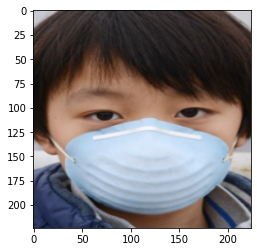

In [ ]:
%matplotlib inline
sample_idxs = [0,1,2,3,4]
for sample_idx in sample_idxs:
    data, label = train_dataset[sample_idx]
    data1 = data[:3, :, :]
    data2 = data[3, :, :]
    plt.imshow(data1.permute(1, 2, 0))
    plt.show()

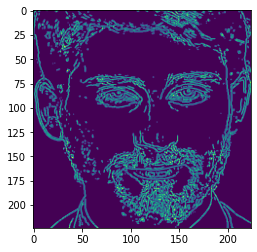

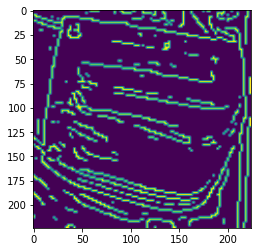

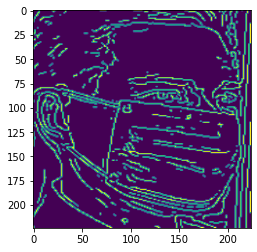

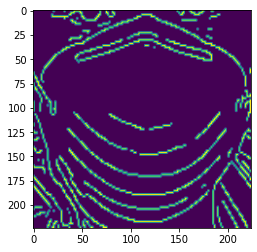

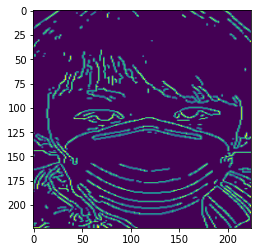

In [ ]:
%matplotlib inline

sample_idxs = [0,1,2,3,4]
for sample_idx in sample_idxs:
    data, label = train_dataset[sample_idx]
    data1 = data[:3, :, :]
    data2 = data[3, :, :]
    plt.imshow(data2)
    plt.show()

## Training the data


We decide to build three different CNN with different complexities, then compare the results(testing accuaracy) of three different CNN. Before setting up the CNN, we set up methods for traning, validating and testing the model. The first function train_validation() is used to train and validate the model. For each epoch, when the model is trained by processing all data from train dataloader, we will validate the accuaracy of model and save the one with the highest validation accuracy. 

In [ ]:
def train_validation(model, criterion, optimizer, epochs):
    model.to(device)
    train_losses = []
    train_accs = []
    validation_losses = []
    validation_accs = []
    best_acc = 0
    best_epoch = 0
    for e in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        validation_loss = 0
        validation_acc = 0
        tc = 0
        tt = 0
        vc = 0
        vt = 0
        for data, labels in train_loader:
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            out = model(data)
            _, preds = torch.max(out.data,1)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (preds == labels).sum().item()
            tc += 1
            tt += labels.size(0)
        train_losses.append(train_loss / tc)
        train_accs.append(train_acc / tt)
        with torch.no_grad():
            model.eval()
            for data, labels in validation_loader:
                data = data.to(device)
                labels = labels.to(device)
                out = model(data)
                _, preds = torch.max(out.data,1)
                loss = criterion(out, labels)
                validation_loss += loss.item()
                validation_acc += (preds == labels).sum().item()
                vc += 1
                vt += labels.size(0)
        validation_losses.append(validation_loss / vc)
        validation_accs.append(validation_acc / vt)
        torch.save(model, '/content/gdrive/MyDrive/CIS545_Final_Project/face-mask-detection/resnetmodel' + str(e) + '.pt')
        print(e)
        if validation_acc / vt > best_acc:
            best_acc = validation_acc / vt
            best_epoch = e
    return train_losses, train_accs, validation_losses, validation_accs, best_epoch

  The second function is designed to test the accuaracy of the model trained and validated through train_validation(). 

In [ ]:
def test(model, criterion):
    model.eval()
    c = 0
    t = 0
    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        for data, labels in train_loader:
            data = data.to(device)
            labels = labels.to(device)
            out = model(data)
            _, preds = torch.max(out.data,1)
            loss = criterion(out, labels)
            test_loss += loss.item()
            test_acc += (preds == labels).sum().item()
            c += 1
            t += labels.size(0)
    testing_loss = test_loss / c 
    testing_accuracy = test_acc / t  
    return  testing_loss, testing_accuracy

### Modified ResNet

  The first CNN we use is Resnet50, this model is the most complex one among the three CNNs. Since the pytorch has already construct the Resnet50, we decide to implement it directly form torchvision.models. By modifying the input size and output feature size corresponding to the data that processed by us. Then, by using the cross entropy loss and adamW optimizer, we could train, validate and test the resnet50 CNN and the results are listed below.

In [ ]:
resnet_50 = models.resnet50()
weight = resnet_50.conv1.weight.clone()
resnet_50.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
with torch.no_grad():
  resnet_50.conv1.weight[:, :3] = weight
  resnet_50.conv1.weight[:, 3] = resnet_50.conv1.weight[:, 0]
num_f = resnet_50.fc.in_features
resnet_50.fc = nn.Linear(num_f, 12)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
lr_optimizer = torch.optim.AdamW(resnet_50.parameters())
epochs = 20
train_losses, train_accs, validation_losses, validation_accs, best_epoch = train_validation(resnet_50,criterion, lr_optimizer, epochs)

From the figure below, we find that the training loss is keep decreasing as expected.

Text(0.5, 1.0, 'training loss vs epochs')

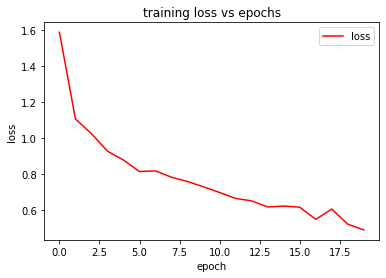

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
x = np.arange(epochs)
plt.plot(x, train_losses, 'r', label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.title('training loss vs epochs') 

From the figure below, we find that the traning accuaracy is keep increasing. The training accuracy could reach 80% after 20 epoch.

Text(0.5, 1.0, 'training accuracy vs epochs')

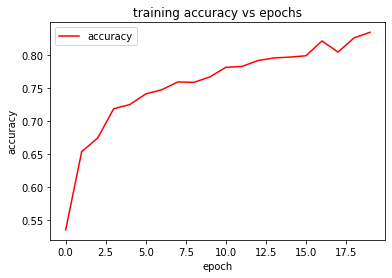

In [ ]:
plt.plot(x, train_accs, 'r', label = 'accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.title('training accuracy vs epochs')

Shown below is the validation losses of each epoch.

Text(0.5, 1.0, 'validation loss vs epochs')

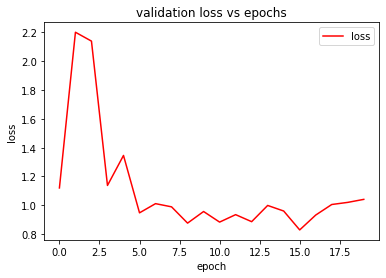

In [ ]:
plt.plot(x, validation_losses, 'r', label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.title('validation loss vs epochs')

Shown below if the validation accuracies of each epoch. At the 9th epoch, the validation accuracy is the hightest.

Text(0.5, 1.0, 'validation accuracy vs epochs')

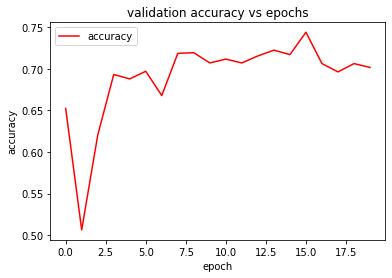

In [ ]:
plt.plot(x, validation_accs, 'r', label = 'accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.title('validation accuracy vs epochs') 

By testing the model from 9th epoch, the testing accuracy is 83.69%.

In [ ]:
model_use = torch.load('/content/gdrive/MyDrive/CIS545_Final_Project/face-mask-detection/resnetmodel' + str(best_epoch) + '.pt')
testing_loss, testing_accuracy = test(model_use,criterion)
print(str(best_epoch) + ', testing_loss is ' + str(testing_loss) + ', testing_accuracy is ' + str(testing_accuracy))

15, testing_loss is 0.47414153845686663, testing_accuracy is 0.8368560105680317


### Model 1

  The second CNN is built based on AlexNet, this CNN is the middle complexity among three CNNs. In this model, there are totally eight layers - five convolutional layers and three linear.We train, validat and test this CNN using the same loss function and optimizer.

In [ ]:
class ALModel(nn.Module):
    def __init__(self):
        super(ALModel, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, 11, 4, 2)
        self.conv2 = nn.Conv2d(16, 64, 5, 1, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, 1 ,1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 1)
        self.conv5 = nn.Conv2d(128, 64, 3, 1, 1)     
        self.pool1 = nn.MaxPool2d(3, 2)
        self.fc1 = nn.Linear(64 * 6 * 6, 2048)
        self.fc2 = nn.Linear(2048, 1000)
        self.fc3 = nn.Linear(1000, 12)
        self.relu = nn.ReLU(True)
        self.drop = nn.Dropout(0.5)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = x.view(-1, 64 * 6 * 6)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
model_al = ALModel()
criterion = nn.CrossEntropyLoss()
al_optimizer = torch.optim.AdamW(model_al.parameters())
epochs = 20
al_train_losses, al_train_accs, al_validation_losses, al_validation_accs, al_best_epoch = train_validation(model_al, criterion, al_optimizer, epochs)

From the figure below, we find that the training loss is keep decreasing as expected.

Text(0.5, 1.0, 'training loss vs epochs')

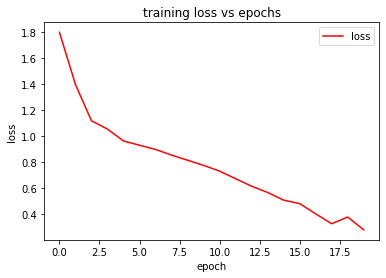

In [ ]:
x = np.arange(epochs)
plt.plot(x, al_train_losses, 'r', label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.title('training loss vs epochs') 

From the figure below, we find that the traning accuaracy is keep increasing. The training accuracy could reach 90% after 20 epoch.

Text(0.5, 1.0, 'training accuracy vs epochs')

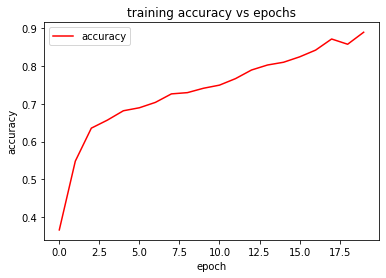

In [ ]:
plt.plot(x, al_train_accs, 'r', label = 'accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.title('training accuracy vs epochs')

Shown below are the validation losses of each epoch. We can see after 7th epoch, the validation loss begins to increase. One possible reason might be that the model is overfitted.

Text(0.5, 1.0, 'validation loss vs epochs')

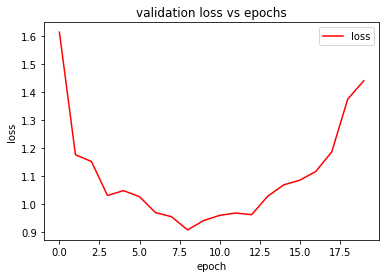

In [ ]:
plt.plot(x, al_validation_losses, 'r', label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.title('validation loss vs epochs')

From the figure below, the group showed the validation accuracies of each epoch. At the 8th epoch, the validation accuracy is the hightest.

Text(0.5, 1.0, 'validation accuracy vs epochs')

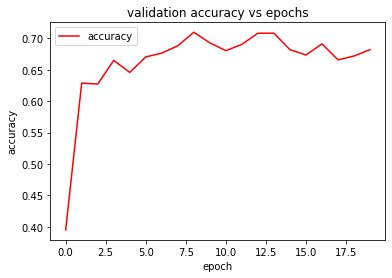

In [ ]:
plt.plot(x, al_validation_accs, 'r', label = 'accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.title('validation accuracy vs epochs') 

By testing the model from 9th epoch, the testing accuracy is 76.52% 

In [ ]:
al_model_use = torch.load('/content/gdrive/MyDrive/CIS545_Final_Project/face-mask-detection/almodel' + str(al_best_epoch) + '.pt')
al_testing_loss, al_testing_accuracy = test(al_model_use,criterion)
print(str(al_best_epoch)  + ', testing_loss is ' + str(al_testing_loss) + ', testing_accuracy is ' + str(al_testing_accuracy))

8 ,testing_loss is 0.7069639491407494 ,testing_accuracy is 0.7651915455746368


### Model 2

  The third CNN was built based on the LeNet-5. This one is the simplest one among three CNNs. It totally contains 5 layers, two convolutional and three linear. By using the same loss function and optimizer, the group trained, validated and tested this CNN.

In [ ]:
class LNModel(nn.Module):
    def __init__(self):
        super(LNModel, self).__init__()
        self.conv1 = nn.Conv2d(4, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*53*53,1000)
        self.fc2 = nn.Linear(1000,500)
        self.fc3 = nn.Linear(500,12)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 53 * 53)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
model_ln = LNModel()
ln_criterion = nn.CrossEntropyLoss()
ln_optimizer = torch.optim.AdamW(model_ln.parameters())
epochs = 20
ln_train_losses, ln_train_accs, ln_validation_losses, ln_validation_accs, ln_best_epoch = train_validation(model_ln, criterion, ln_optimizer, epochs)

The figure below showed the train loss of each epoch.

Text(0.5, 1.0, 'validation accuracy vs epochs')

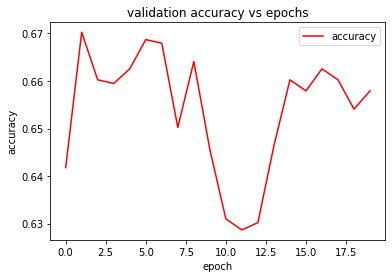

In [ ]:
plt.plot(x, ln_train_losses, 'r', label = 'accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.title('train loss vs epochs') 

From the figure below, the group found that the traning accuaracy is keep increasing. The training accuracy could almost reach 99% after 20 epoch.

Text(0.5, 1.0, 'training accuracy vs epochs')

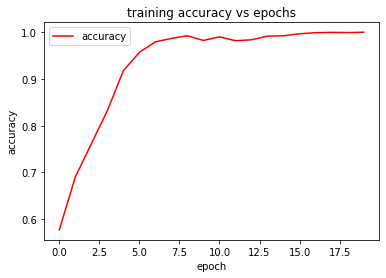

In [ ]:
plt.plot(x, ln_train_accs, 'r', label = 'accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.title('training accuracy vs epochs')

From the figure below, the group showed the validate loss of each epoch.

Text(0.5, 1.0, 'validation loss vs epochs')

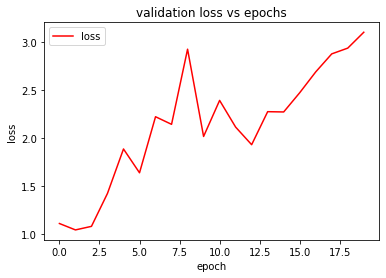

In [ ]:
plt.plot(x, ln_validation_losses, 'r', label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.title('validation loss vs epochs')

From the figure below, the group showed the validation accuracies of each epoch. At the 1st epoch, the validation accuracy is the hightest.

Text(0.5, 1.0, 'validation accuracy vs epochs')

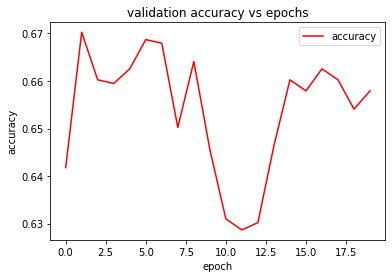

In [ ]:
plt.plot(x, ln_validation_accs, 'r', label = 'accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.title('validation accuracy vs epochs') 

By testing the model from 9th epoch, the testing accuracy is 73.35%

In [ ]:
ln_model_use = torch.load('/content/gdrive/MyDrive/CIS545_Final_Project/face-mask-detection/lnmodel' + str(ln_best_epoch) + '.pt')
ln_testing_loss, ln_testing_accuracy = test(ln_model_use,ln_criterion)
print(str(ln_best_epoch) + ', testing_loss is ' + str(ln_testing_loss) + ', testing_accuracy is ' + str(ln_testing_accuracy))

1 ,testing_loss is 0.7908502792057238 ,testing_accuracy is 0.7334874504623514


##Result and Analysis

From the results above, we can find that all three models achive 70%+ testing accuracy by using test dataset. Among these three models, Resnet50 has the hightest testing accuracy, which is 83.69%. Therefore, we choose to use this model to predict the classname of each images listed in submission.csv. MTCNN is used to detect faces in each image. Then crop the original image and the edge dectected image to pass the CNN model to predict the classname. 

In [ ]:
def getResult(image_folder, edge_folder, model, mask_category):
  model = model.to(device)
  detector = MTCNN()
  result_df = pd.DataFrame(columns=['name', 'x1', 'x2', 'y1', 'y2', 'classname'])
  data_transforms = transforms.Compose([
                    transforms.Resize((224,224)), 
                    transforms.ToTensor(),
                    ])
  key_list = list(mask_category.keys())
  val_list = list(mask_category.values())
  row_index = 0
  for i in submission_df_copy['name']:
    image_path = os.path.join(image_folder, i)
    img = plt.imread(image_path)
    face = detector.detect_faces(img)
    for f in face:
      boundary = f['box']
      x1 = boundary[0]
      x2 = boundary[1]
      y1 = boundary[0] + boundary[2]
      y2 = boundary[1] + boundary[3]
      img = Image.open(image_path)
      image_crop = img.crop((x1, x2, y1, y2))
      image_crop_trans = data_transforms(image_crop)
      pil_name = i.split('.')[0] + '.png'
      pil_path = os.path.join(edge_folder, pil_name)
      pil_img = Image.open(pil_path)
      pil_crop = pil_img.crop((x1, x2, y1, y2))
      pil_crop_trans = data_transforms(pil_crop)
      out_image = torch.zeros(4,224,224)
      out_image[:3, :, :] = image_crop_trans
      out_image[3, :, :] = pil_crop_trans
      out_image = out_image.unsqueeze(0)
      out_image = out_image.to(device)
      out = model(out_image)
      _, predict = torch.max(out.data,1)
      index = val_list.index(predict)
      classname = key_list[index]
      result_df.loc[row_index]={'name': i, 'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'classname': classname}
      row_index += 1
      print(row_index)
  return result_df

In [ ]:
model_use = torch.load('/content/gdrive/MyDrive/CIS545_Final_Project/face-mask-detection/resnetmodel16.pt')
result_df = getResult(img_folder, sav_folder, model_use, mask_category)
result_df

0001.jpg
0003.jpg
0004.jpg
0006.jpg
0007.jpg
0007.jpg
0007.jpg
0007.jpg
0009.jpg
0010.jpg


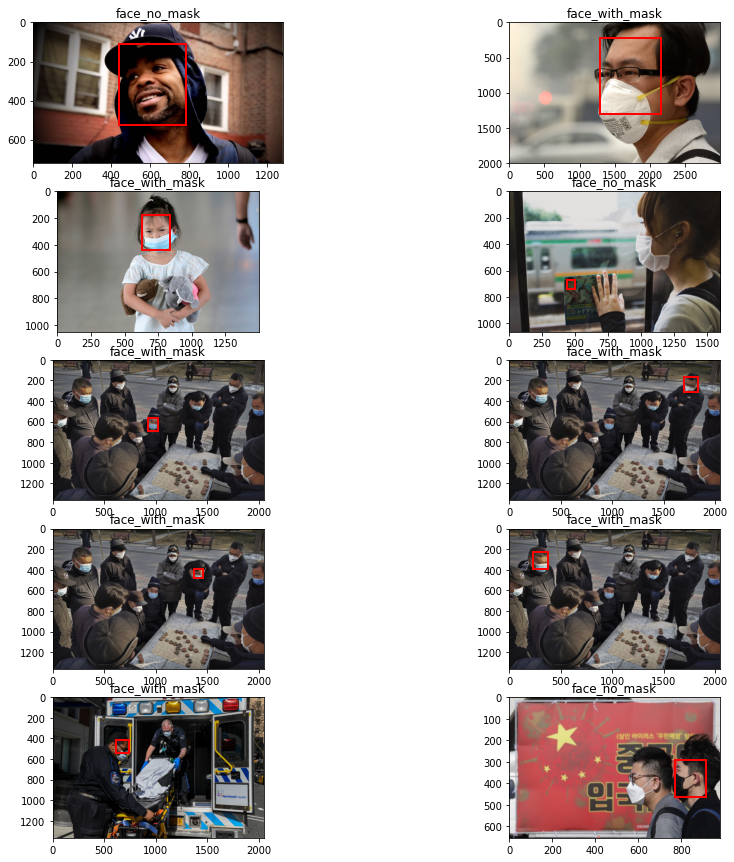

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10 = ax.flatten()
x1, x2, y1, y2, classname, image_plt = face_mask_rectangle(0, result_df)
ax1.imshow(image_plt)
rect1 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax1.set_title(classname)

x1, x2, y1, y2, classname, image_plt = face_mask_rectangle(1, result_df)
ax2.imshow(image_plt)
rect2 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax2.set_title(classname)

x1, x2, y1, y2, classname, image_plt = face_mask_rectangle(2, result_df)
ax3.imshow(image_plt)
rect3 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax3.set_title(classname)

x1, x2, y1, y2, classname, image_plt = face_mask_rectangle(3, result_df)
ax4.imshow(image_plt)
rect4 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax4.set_title(classname)

x1, x2, y1, y2, classname, image_plt = face_mask_rectangle(4, result_df)
ax5.imshow(image_plt)
rect5 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax5.set_title(classname)

x1, x2, y1, y2, classname, image_plt = face_mask_rectangle(5, result_df)
ax6.imshow(image_plt)
rect6 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax6.set_title(classname)

x1, x2, y1, y2, classname, image_plt = face_mask_rectangle(6, result_df)
ax7.imshow(image_plt)
rect7 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax7.set_title(classname)

x1, x2, y1, y2, classname, image_plt = face_mask_rectangle(7, result_df)
ax8.imshow(image_plt)
rect8 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax8.set_title(classname)

x1, x2, y1, y2, classname, image_plt = face_mask_rectangle(8, result_df)
ax9.imshow(image_plt)
rect9 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax9.set_title(classname)

x1, x2, y1, y2, classname, image_plt = face_mask_rectangle(9, result_df)
ax10.imshow(image_plt)
rect10 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax10.set_title(classname)


ax1.add_patch(rect1)
ax2.add_patch(rect2)
ax3.add_patch(rect3)
ax4.add_patch(rect4)
ax5.add_patch(rect5)
ax6.add_patch(rect6)
ax7.add_patch(rect7)
ax8.add_patch(rect8)
ax9.add_patch(rect9)
ax10.add_patch(rect10)

plt.show()

Shown above are the first several outputs from our result_df. As we can see, most faces and masks are detected correctly. However, one major issue is that for the face detection package MTCNN we use to detect faces in testing images, it fails to detect side faces most of the time. Also, it falis to include the complete face mask into the red box. What's more, when an image has multiple faces, it fails to detect all of them. The deficiency of MTCNN is a major factor that affects our model accuracy. For example in 0006.jpg, the side face is not detected, while the face on the post card (although it's supper tiny) is marked as the target to do face mask detection. For 0003.jpg, only part of the face mask is included, it might cause the model fail to detect what category it fits in. For 0007.jpg, only four faces are deteced. Similar issues also can be seen from 0009.jpg and 0010.jpg. For 0004.jpg, face are detected successfully, however it fails to detect the surgical mask type. Overall, the accuracy of detecting whether people are wearing face masks or not is pretty satidfying, but the model fails to detect what category the face masks fit in due to the deficiency of MTCNN.

The most challenging part of this project is how we add more features to our our dataset in order to increase the prediction accuracy of our models. We read some articles relavant to computer vision topics and decide to implement edge detection in our project since edges are most important and indicative feature of an image. After reading some papers and checking relavant resources, we found that the average accuracy of resnet model is around 75%. Our modified resnet model, in cooperation with the implementation of canny edge detection, has an average accuracy around 80%, which indicates that the edge detection is very likely a good practice for computer vision related machine learning project. Due to the limited time we haven't had a chance to run the model on dataset without the implementation of canny edge detection and compare to the current result. However, edge detection is indeed a meaningful approach to consider.

Our future step would be to improve MTCNN to make sure that it is capacble of dealing with side faces, multiple faces in a single image and make sure that faces with various object can be detected completely. Also, it would be better to implement a mask detection package seperately to help distinguish which category it falls for a mask detected in an image.